## 1. Make Classification Data

In [1]:
import sklearn
from sklearn.datasets import make_circles

#make 1k sample
n_samples = 1000

#create circle
X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                   "X2": X[:,1],
                   "label": y})

circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


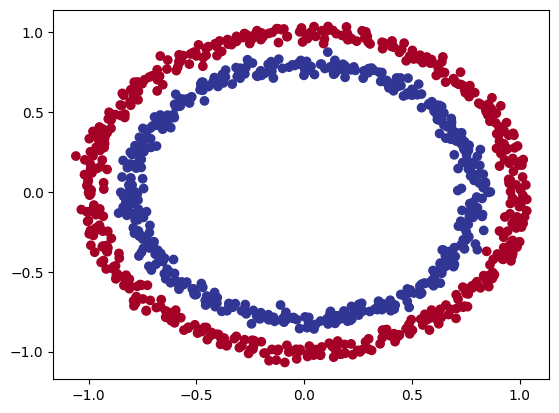

In [5]:
#data Viz
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check Input Output Shape

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
#View the first example of features and Labels
X_sample = X[0]
y_sample = y[0]

print(X_sample, y_sample)
print(X_sample.shape, y_sample.shape)


[0.75424625 0.23148074] 1
(2,) ()


### 1.2 in to Tensor and train test split

In [8]:
import torch
torch.__version__

'2.3.0+cu121'

In [9]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
type(X), type(y), X.dtype, y.dtype # it will be in 32

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)


In [13]:
#builting a model
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [14]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cpu')

In [16]:
#lets replicate with nn.sequntail
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5425,  0.0806],
                      [-0.0617, -0.5902],
                      [-0.1781,  0.3208],
                      [ 0.0508,  0.6580],
                      [-0.4360, -0.1243]])),
             ('0.bias', tensor([ 0.2502,  0.0136, -0.0896,  0.3920,  0.2628])),
             ('1.weight',
              tensor([[ 0.0100, -0.1482,  0.3838,  0.4333,  0.1697]])),
             ('1.bias', tensor([-0.2119]))])

In [18]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Lenght of Predictions{len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Lenght of test samples{len(X_test)}, Shape: {X_test.shape}")
print(f"\nfirst 10 predictions{untrained_preds[:10]}")
print(f"\nfirst 10 labels:\n{y_test[:10]}")

Lenght of Predictions200, Shape: torch.Size([200, 1])
Lenght of test samples200, Shape: torch.Size([200, 2])

first 10 predictionstensor([[ 0.3330],
        [ 0.4235],
        [-0.1066],
        [ 0.4583],
        [-0.4275],
        [-0.3697],
        [ 0.1396],
        [-0.0470],
        [-0.0924],
        [ 0.4260]])

first 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [19]:
#loss ft and optim
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

1. Forward Pass
2. Cal loss
3. optim zeor grad
4. Loss back
5. Optim step step

logit are raw output fo model for exmpel in next cell

In [21]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.3330],
        [ 0.4235],
        [-0.1066],
        [ 0.4583],
        [-0.4275]])

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5825],
        [0.6043],
        [0.4734],
        [0.6126],
        [0.3947]])

In [25]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]])

In [26]:
# Building Training and Testing Loops


In [27]:
device

'cpu'

In [28]:
torch.manual_seed(42)
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  training_loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  training_loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Training Loss: {training_loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")







Epoch: 0 | Training Loss: 0.70322, Accuracy: 50.38% | Test loss: 0.71338, Test acc: 47.00%
Epoch: 10 | Training Loss: 0.70110, Accuracy: 50.50% | Test loss: 0.71032, Test acc: 47.50%
Epoch: 20 | Training Loss: 0.69951, Accuracy: 50.25% | Test loss: 0.70792, Test acc: 48.00%
Epoch: 30 | Training Loss: 0.69830, Accuracy: 50.50% | Test loss: 0.70600, Test acc: 48.50%
Epoch: 40 | Training Loss: 0.69736, Accuracy: 50.62% | Test loss: 0.70444, Test acc: 48.50%
Epoch: 50 | Training Loss: 0.69662, Accuracy: 50.62% | Test loss: 0.70315, Test acc: 48.50%
Epoch: 60 | Training Loss: 0.69603, Accuracy: 50.50% | Test loss: 0.70208, Test acc: 49.00%
Epoch: 70 | Training Loss: 0.69555, Accuracy: 50.62% | Test loss: 0.70118, Test acc: 49.00%
Epoch: 80 | Training Loss: 0.69516, Accuracy: 50.75% | Test loss: 0.70041, Test acc: 49.00%
Epoch: 90 | Training Loss: 0.69483, Accuracy: 50.75% | Test loss: 0.69975, Test acc: 49.00%
Epoch: 100 | Training Loss: 0.69457, Accuracy: 50.75% | Test loss: 0.69918, Test 

In [29]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

  from helper_functions import plot_decision_boundary



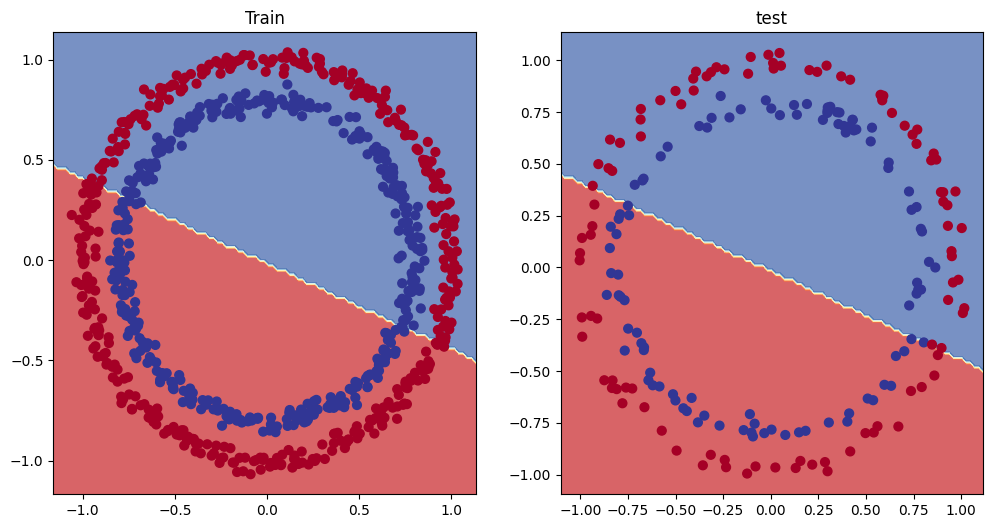

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

In [31]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5640,  0.0510],
                      [-0.0575, -0.5828],
                      [-0.0986,  0.1749],
                      [ 0.1318,  0.5059],
                      [-0.3883, -0.2077]])),
             ('0.bias', tensor([ 0.2530,  0.0107, -0.0695,  0.4134,  0.2737])),
             ('1.weight', tensor([[0.1466, 0.1144, 0.2230, 0.2069, 0.1513]])),
             ('1.bias', tensor([-0.1488]))])

In [32]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    #down is better approach
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [34]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr = 0.1)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  training_loss = loss_fn(y_logits, y_train)
  training_acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  training_loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
     print(f"Epoch: {epoch} | Training Loss: {training_loss:.5f}, Accuracy: {training_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Training Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Training Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Training Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Training Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Training Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Training Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Training Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Training Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Training Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Training Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


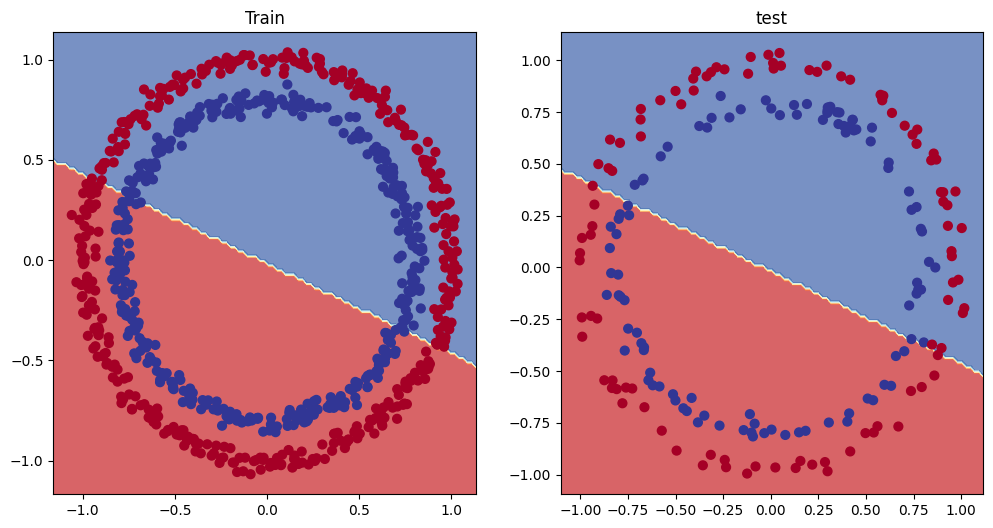

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)

# Traing circles mdoel on linear data

In [37]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias
print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:
# Create train/test split
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set, 20% for testing
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

In [39]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

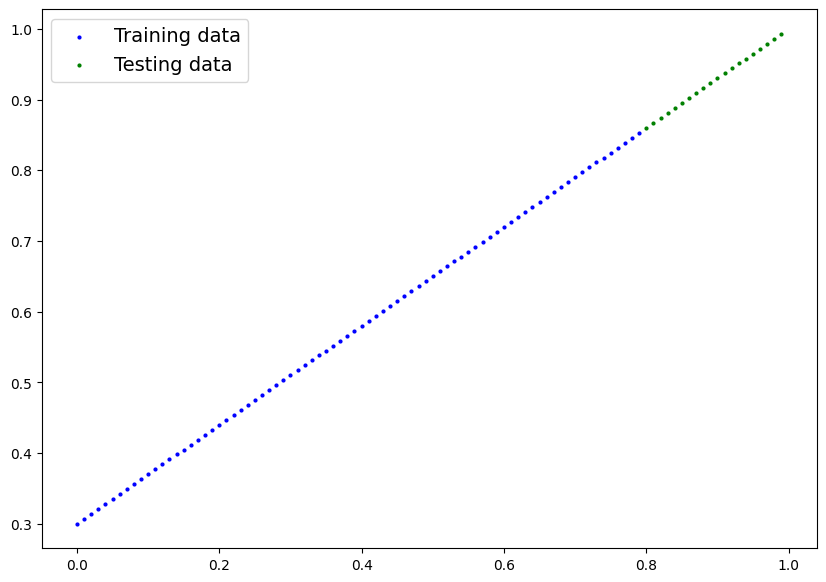

In [40]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression);



In [41]:
X_train_regression[:10], y_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [42]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [45]:
torch.manual_seed(42)
epochs =1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  train_loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Training Loss: {train_loss:.5f}| Test loss: {test_loss:.5f}")





Epoch: 0 | Training Loss: 0.75986| Test loss: 0.91103
Epoch: 100 | Training Loss: 0.02858| Test loss: 0.00081
Epoch: 200 | Training Loss: 0.02533| Test loss: 0.00209
Epoch: 300 | Training Loss: 0.02137| Test loss: 0.00305
Epoch: 400 | Training Loss: 0.01964| Test loss: 0.00341
Epoch: 500 | Training Loss: 0.01940| Test loss: 0.00387
Epoch: 600 | Training Loss: 0.01903| Test loss: 0.00379
Epoch: 700 | Training Loss: 0.01878| Test loss: 0.00381
Epoch: 800 | Training Loss: 0.01840| Test loss: 0.00329
Epoch: 900 | Training Loss: 0.01798| Test loss: 0.00360


In [46]:
# class CircleModelV1_linear(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.layer_1 = nn.Linear(in_features=2, out_features=10)
#     self.layer_2 = nn.Linear(in_features=10, out_features=10)
#     self.layer_3 = nn.Linear(in_features=10, out_features=1)
#   def forward(self, x):
#     # z = self.layer_1(x)
#     # z = self.layer_2(z)
#     # z = self.layer_3(z)
#     #down is better approach
#     return self.layer_3(self.layer_2(self.layer_1(x)))

# model_1 = CircleModelV1().to(device)
# model_1

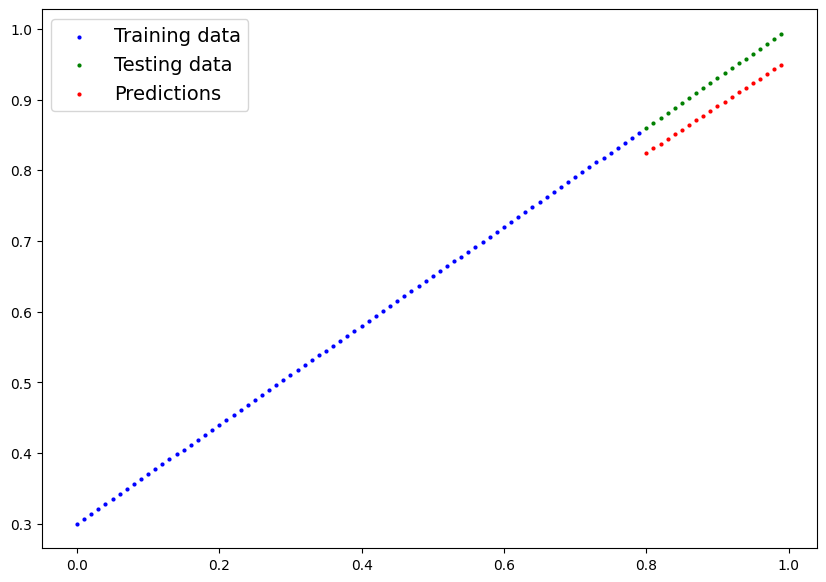

In [47]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression,
                 predictions=test_pred);

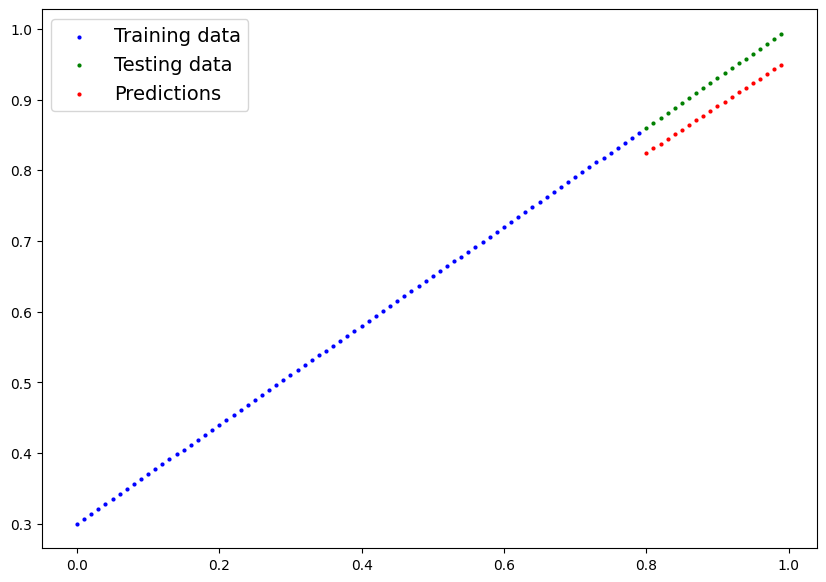

In [48]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)
  plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression,
                 predictions=y_preds);



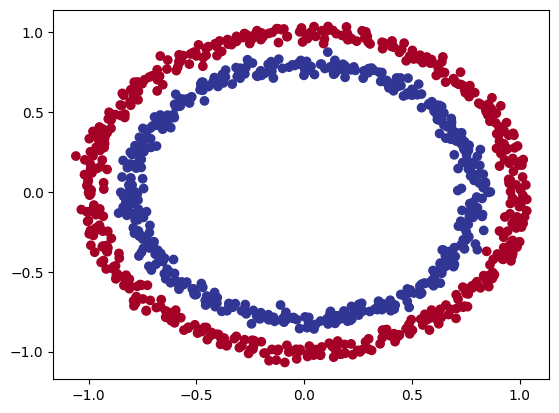

In [49]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42,)

plt.scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.RdYlBu)



In [50]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [51]:
#building a mode with non linearity
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=128)
    self.layer_2 = nn.Linear(in_features=128, out_features=64)
    self.layer_3 = nn.Linear(in_features=64, out_features=32)
    self.layer_4 = nn.Linear(in_features=32, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

epochs =1000

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  train_loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_true=y_train,
                          y_pred=y_pred)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc  = accuracy_fn(y_true=y_test,
                          y_pred=test_pred)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}| Loss: {train_loss:.4f}% | test loss: {test_loss:.4f}% | Test Acc: {test_acc}%")



Epoch: 0| Loss: 0.6948% | test loss: 0.6947% | Test Acc: 50.0%
Epoch: 100| Loss: 0.6901% | test loss: 0.6914% | Test Acc: 72.0%
Epoch: 200| Loss: 0.6848% | test loss: 0.6873% | Test Acc: 59.0%
Epoch: 300| Loss: 0.6701% | test loss: 0.6759% | Test Acc: 61.0%
Epoch: 400| Loss: 0.6044% | test loss: 0.6206% | Test Acc: 87.0%
Epoch: 500| Loss: 0.4403% | test loss: 0.4926% | Test Acc: 65.0%
Epoch: 600| Loss: 0.3155% | test loss: 0.3826% | Test Acc: 78.0%
Epoch: 700| Loss: 0.0431% | test loss: 0.0694% | Test Acc: 100.0%
Epoch: 800| Loss: 0.0190% | test loss: 0.0366% | Test Acc: 100.0%
Epoch: 900| Loss: 0.0116% | test loss: 0.0254% | Test Acc: 100.0%


In [54]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]


(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

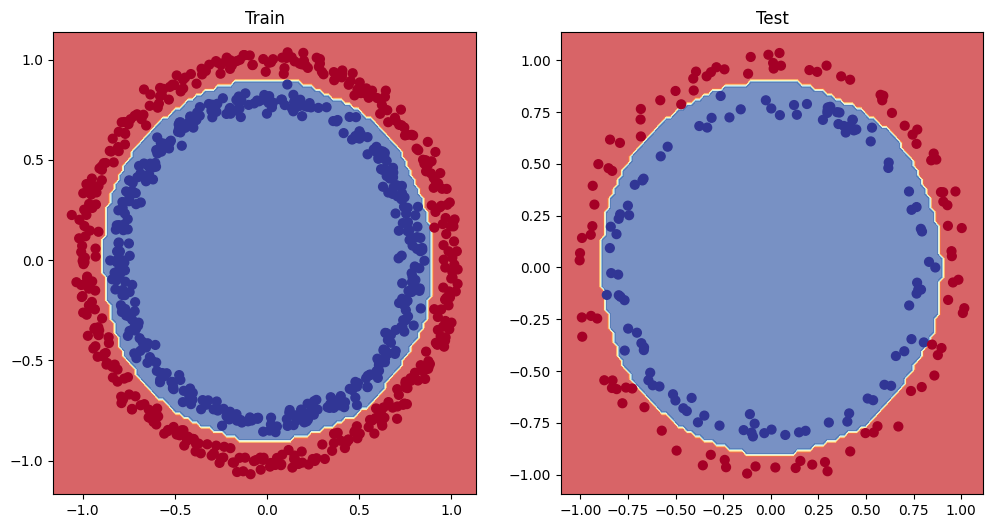

In [55]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test,y_test)


In [56]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5794,  0.6294],
                      [-0.2972,  0.7880],
                      [-0.1540,  0.1516],
                      [-0.4736,  0.5610],
                      [ 0.6320, -0.5150],
                      [ 0.5629,  0.1219],
                      [ 0.5555,  0.1093],
                      [ 0.3239, -0.0945],
                      [ 0.6193,  0.1164],
                      [-0.3479,  0.2033],
                      [-0.3953, -0.0888],
                      [-0.4026,  0.5847],
                      [-0.7344, -0.3708],
                      [-0.1997, -0.4252],
                      [ 0.0986, -0.7838],
                      [ 0.7365, -0.7797],
                      [ 0.4858,  0.1062],
                      [-0.2049,  0.4714],
                      [ 0.1685,  0.6372],
                      [ 0.0806, -0.2539],
                      [ 0.1900, -0.1918],
                      [ 0.3094,  0.7281],
                      [ 0.4885, -0.3554],
  

In [57]:
A = torch.arange(-10, 10. -1, dtype=torch.float32)
A.dtype

torch.float32

In [58]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.])

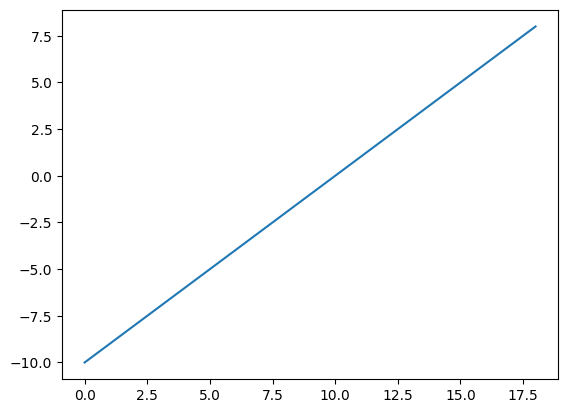

In [59]:
plt.plot(A)

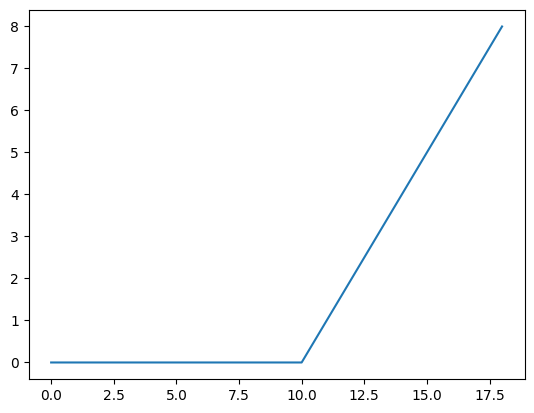

In [60]:
plt.plot(torch.relu(A))

In [61]:
def relu(x):
  return torch.max(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8.])

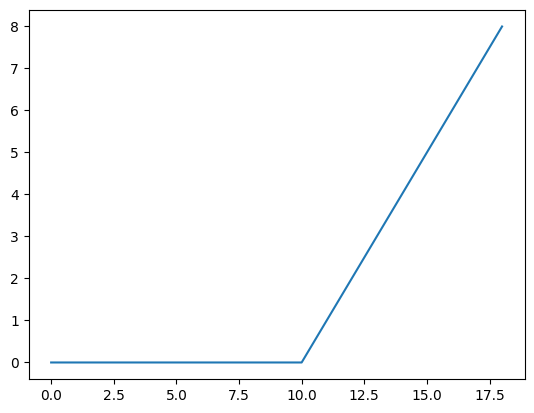

In [62]:
plt.plot(relu(A))

In [63]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

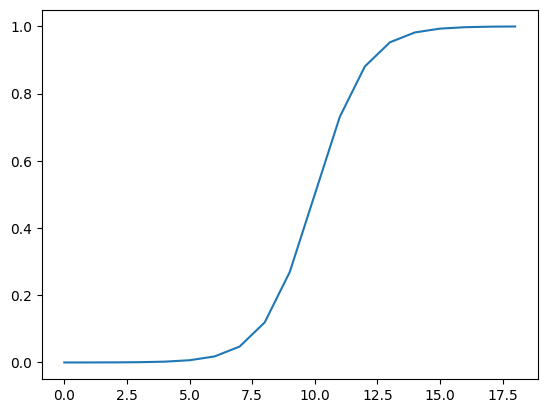

In [64]:
plt.plot(torch.sigmoid(A))

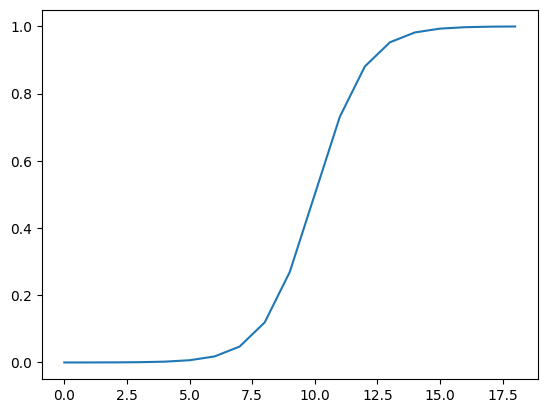

In [65]:
plt.plot(sigmoid(A))

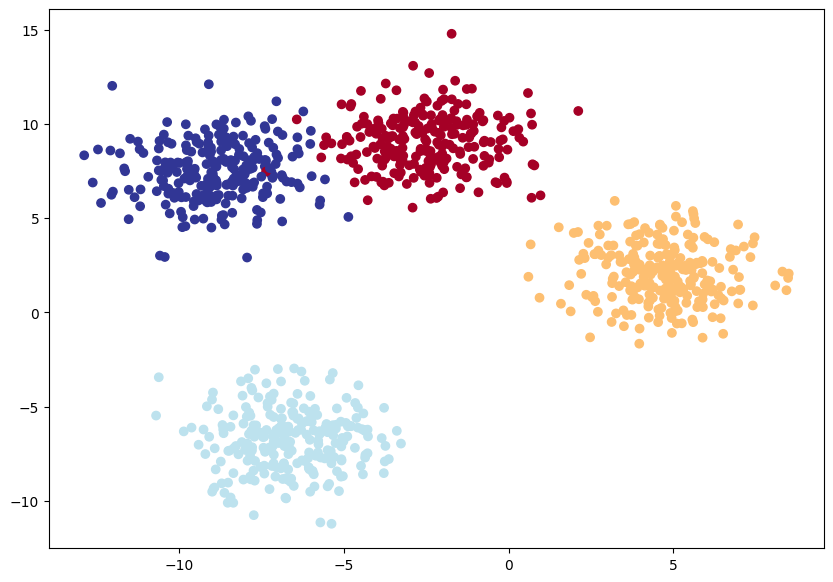

In [123]:
import torch
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size =0.2,
                                                                        random_state = RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [124]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [125]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [126]:
#create a losss funcction for

floss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)


In [127]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]])

In [128]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [129]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs)

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951],
        [0.2788, 0.0088, 0.2893, 0.4232],
        [0.3246, 0.1261, 0.4545, 0.0948],
        [0.2229, 0.0443, 0.1867, 0.5461],
        [0.3447, 0.0368, 0.5269, 0.0917],
        [0.2145, 0.0510, 0.1752, 0.5593],
        [0.2387, 0.0384, 0.2089, 0.5140],
        [0.1700, 0.3350, 0.1317, 0.3634],
        [0.1987, 0.0519, 0.1561, 0.5933],
        [0.2039, 0.0381, 0.1639, 0.5940],
        [0.1916, 0.0363, 0.1497, 0.6224],
        [0.2758, 0.0198, 0.2725, 0.4319],
        [0.2838, 0.0137, 0.2919, 0.4105],
        [0.3371, 0.0711, 0.4241, 0.1677],
        [0.26

In [130]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [131]:
torch.max(y_pred_probs[0])

tensor(0.3715)

In [132]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [137]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs =100
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits=model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test, y_pred= test_preds)

  if epoch % 10 == 0:
    print(f"epochs:{epoch} | Loss: {loss:.4f} | Acc: {acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")







epochs:0 | Loss: 0.0256 | Acc: 99.2500 | Test Loss: 0.0150 | Test Acc: 99.5000
epochs:10 | Loss: 0.0255 | Acc: 99.2500 | Test Loss: 0.0148 | Test Acc: 99.5000
epochs:20 | Loss: 0.0255 | Acc: 99.2500 | Test Loss: 0.0147 | Test Acc: 99.5000
epochs:30 | Loss: 0.0254 | Acc: 99.2500 | Test Loss: 0.0146 | Test Acc: 99.5000
epochs:40 | Loss: 0.0253 | Acc: 99.2500 | Test Loss: 0.0145 | Test Acc: 99.5000
epochs:50 | Loss: 0.0252 | Acc: 99.2500 | Test Loss: 0.0144 | Test Acc: 99.5000
epochs:60 | Loss: 0.0252 | Acc: 99.2500 | Test Loss: 0.0143 | Test Acc: 99.5000
epochs:70 | Loss: 0.0251 | Acc: 99.2500 | Test Loss: 0.0142 | Test Acc: 99.5000
epochs:80 | Loss: 0.0250 | Acc: 99.2500 | Test Loss: 0.0141 | Test Acc: 99.5000
epochs:90 | Loss: 0.0250 | Acc: 99.2500 | Test Loss: 0.0140 | Test Acc: 99.5000


In [140]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  6.1094,  15.6397, -20.3870, -13.3337],
        [  7.1567, -18.6720,   5.0192,  14.9407],
        [ -8.2555, -19.4455,  28.1671,  16.7753],
        [  2.4858,  11.6568, -11.9604,  -9.7612],
        [ 11.5600,   4.4088, -19.5413,  -4.4751],
        [  7.9940, -23.1947,   7.3453,  18.6133],
        [ -8.8247, -14.5795,  25.1794,  12.7981],
        [ 10.1216,  -1.6690, -12.6660,   0.6592],
        [ -8.2453, -27.4782,  34.4588,  23.4128],
        [ 10.4646,   0.5659, -14.9222,  -1.2143]])

In [141]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[7.2619e-05, 9.9993e-01, 2.2583e-16, 2.6122e-13],
        [4.1615e-04, 2.5234e-15, 4.9085e-05, 9.9953e-01],
        [1.5202e-16, 2.0995e-21, 9.9999e-01, 1.1287e-05],
        [1.0400e-04, 9.9990e-01, 5.5350e-11, 4.9917e-10],
        [9.9922e-01, 7.8337e-04, 3.1085e-14, 1.0857e-07],
        [2.4439e-05, 6.9662e-19, 1.2774e-05, 9.9996e-01],
        [1.7068e-15, 5.4065e-18, 1.0000e+00, 4.1962e-06],
        [9.9991e-01, 7.5748e-06, 1.2689e-10, 7.7713e-05],
        [2.8434e-19, 1.2621e-27, 9.9998e-01, 1.5952e-05],
        [9.9994e-01, 5.0239e-05, 9.4329e-12, 8.4703e-06]])

In [143]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

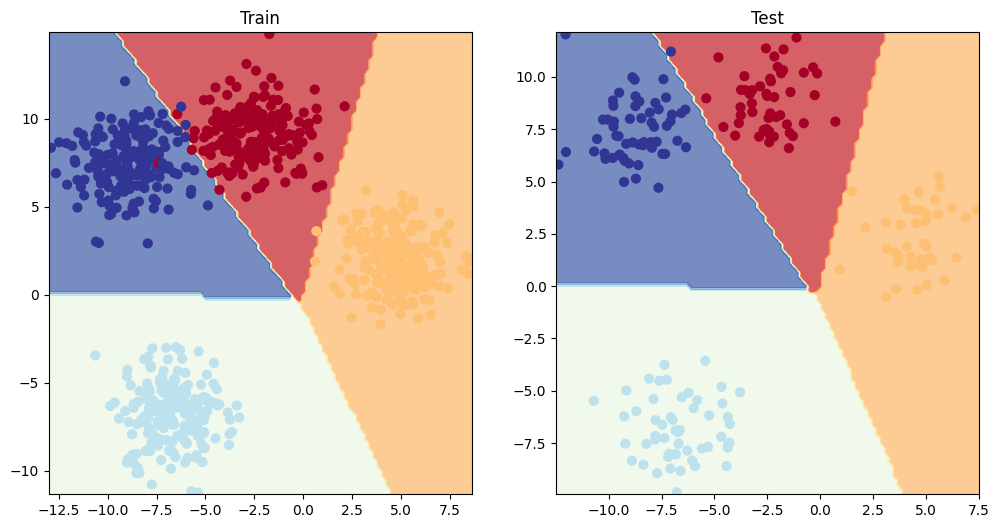

In [146]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [148]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [153]:
from torchmetrics import Accuracy
torchmetrices_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
torchmetrices_accuracy(y_preds, y_blob_test)


tensor(0.9950)